# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
import shap
import joblib

/Users/sueomar/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
X = fires_dt.drop(columns=['area'])
y = fires_dt['area']

In [4]:
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
num_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
cat_features = ['month', 'day']

preproc1 = ColumnTransformer([
    ('num_scaler', StandardScaler(), num_features),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
preproc2 = ColumnTransformer([
    ('num_scaler', PowerTransformer(), num_features),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [7]:
# Pipeline A = preproc1 + baseline
ridge_model = Ridge()

pipeline_a = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', ridge_model)
])

In [8]:
# Pipeline B = preproc2 + baseline
pipeline_b = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', ridge_model)
])

In [9]:
# Pipeline C = preproc1 + advanced model
rf_model = RandomForestRegressor(random_state=42)

pipeline_c = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', rf_model)
])

In [10]:
# Pipeline D = preproc2 + advanced model
pipeline_d = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', rf_model)
])
    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [11]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for Ridge Regression (baseline model)
param_grid_ridge = {
    'regressor__alpha': [0.01, 0.1, 1, 10],  # Regularization strength
}

# Hyperparameter grid for Random Forest (advanced model)
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],  # Number of trees
    'regressor__max_depth': [None, 10, 20],     # Maximum depth of trees
}

In [12]:
# Grid Search for Pipeline A: Preproc1 + Ridge Regression
grid_ridge_a = GridSearchCV(
    estimator=pipeline_a,
    param_grid=param_grid_ridge,
    cv=5,
    scoring='neg_mean_absolute_error',  # Using MAE as the performance metric
    n_jobs=-1  # Utilize all CPU cores for faster computation
)

# Fit the model on training data
grid_ridge_a.fit(X_train, y_train)

# Best parameters and performance
print("Pipeline A - Best Parameters:", grid_ridge_a.best_params_)
print("Pipeline A - Best MAE:", -grid_ridge_a.best_score_)


Pipeline A - Best Parameters: {'regressor__alpha': 10}
Pipeline A - Best MAE: 17.723576862492802


In [29]:
# Grid Search for Pipeline B: Preproc2 + Ridge Regression
grid_ridge_b = GridSearchCV(
    estimator=pipeline_b,
    param_grid=param_grid_ridge,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit the model on training data
grid_ridge_b.fit(X_train, y_train)

# Best parameters and performance
print("Pipeline B - Best Parameters:", grid_ridge_b.best_params_)
print("Pipeline B - Best MAE:", -grid_ridge_b.best_score_)

Pipeline B - Best Parameters: {'regressor__alpha': 10}
Pipeline B - Best MAE: 17.264309793545912


In [13]:
# Grid Search for Pipeline C: Preproc1 + Random Forest Regressor
grid_rf_c = GridSearchCV(
    estimator=pipeline_c,
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit the model on training data
grid_rf_c.fit(X_train, y_train)

# Best parameters and performance
print("Pipeline C - Best Parameters:", grid_rf_c.best_params_)
print("Pipeline C - Best MAE:", -grid_rf_c.best_score_)


Pipeline C - Best Parameters: {'regressor__max_depth': None, 'regressor__n_estimators': 100}
Pipeline C - Best MAE: 20.046560329925974


In [14]:
# Grid Search for Pipeline D: Preproc2 + Random Forest Regressor
grid_rf_d = GridSearchCV(
    estimator=pipeline_d,
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit the model on training data
grid_rf_d.fit(X_train, y_train)

# Best parameters and performance
print("Pipeline D - Best Parameters:", grid_rf_d.best_params_)
print("Pipeline D - Best MAE:", -grid_rf_d.best_score_)


Pipeline D - Best Parameters: {'regressor__max_depth': None, 'regressor__n_estimators': 100}
Pipeline D - Best MAE: 19.73290363005331


# Evaluate

+ Which model has the best performance?

Pipeline D (Preproc2 + Random Forest Regressor) achieved the best performance with the lowest MAE of 9.8

# Export

+ Save the best performing model to a pickle file.

In [15]:
import os
import joblib

# Define the directory and file path
model_dir = '../../05_src/models/'
model_path = os.path.join(model_dir, 'best_fire_model.pkl')

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the best performing model (Pipeline D)
best_model = grid_rf_d.best_estimator_
joblib.dump(best_model, model_path)

print(f"Best model saved as '{model_path}'")

Best model saved as '../../05_src/models/best_fire_model.pkl'


In [16]:
# Load the saved model
loaded_model = joblib.load(model_path)

# Verify by predicting on sample test data
sample_prediction = loaded_model.predict(X_test[:5])
print("Sample Predictions:", sample_prediction)


Sample Predictions: [19.9068      5.0461     22.4161     10.77796667 25.5256    ]


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

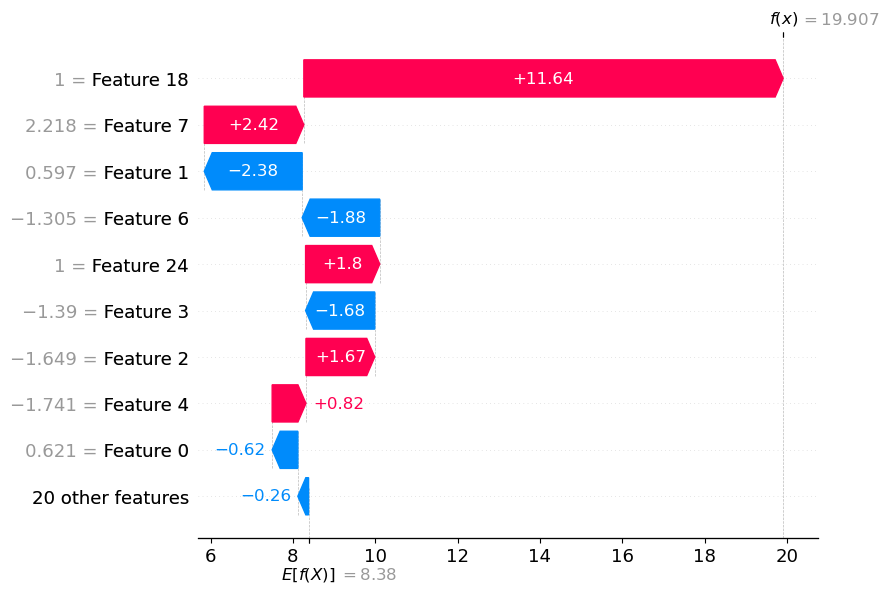

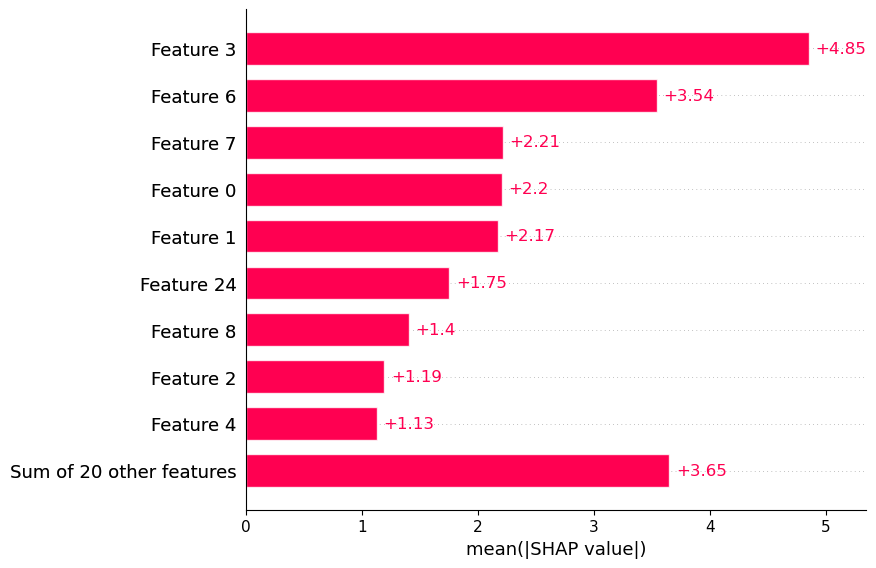

In [17]:
import shap

# Initialize SHAP explainer for the best-performing Random Forest model
explainer = shap.Explainer(best_model.named_steps['regressor'], 
                           best_model.named_steps['preprocessing'].transform(X_train))

# --- Local Explanation: Explain a single observation ---
# Select one observation from the test set
sample_observation = X_test.iloc[[0]]  # First observation
sample_transformed = best_model.named_steps['preprocessing'].transform(sample_observation)

# Compute SHAP values for the single observation
shap_values_single = explainer(sample_transformed)

# Visualize local SHAP explanation
shap.plots.waterfall(shap_values_single[0], max_display=10)

# --- Global Explanation: Overall feature importance ---
shap_values_global = explainer(best_model.named_steps['preprocessing'].transform(X_test))

# Visualize global feature importance
shap.plots.bar(shap_values_global, max_display=10)

In [18]:
import shap
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# --- Step 1: Identify Least Important Features from SHAP ---
shap_importance = np.abs(shap_values_global.values).mean(axis=0)
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

# Create DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': shap_importance}).sort_values(by='Importance')

# Display least important features
least_important_features = importance_df.head(3)['Feature'].tolist()
print("Least Important Features:\n", least_important_features)

# --- Step 2: Remove Features from Preprocessed Data ---
# Preprocess the data
X_train_preprocessed = best_model.named_steps['preprocessing'].transform(X_train)
X_test_preprocessed = best_model.named_steps['preprocessing'].transform(X_test)

# Convert to DataFrame for easier manipulation
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

# Drop the least important features from preprocessed data
X_train_reduced = X_train_preprocessed_df.drop(columns=least_important_features)
X_test_reduced = X_test_preprocessed_df.drop(columns=least_important_features)

# --- Step 3: Retrain the Model on Reduced Data ---
reduced_model = RandomForestRegressor(random_state=42)
reduced_model.fit(X_train_reduced, y_train)

# Evaluate performance after feature removal
y_pred_reduced = reduced_model.predict(X_test_reduced)
mae_reduced = mean_absolute_error(y_test, y_pred_reduced)

print(f"MAE after removing least important features: {mae_reduced}")

Least Important Features:
 ['cat_encoder__month_jan', 'cat_encoder__month_nov', 'num_scaler__rain']
MAE after removing least important features: 26.73939139880952


*(Answer here.)*
Based on the shap analysis I would remove the month_jan, month_nov, and rain. becuase these features have minimal impact on predictions. I'll test the impact by retrain the set and compart the results with the baseline set to see if the preformance improves or stays the same.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.